# Iterative Prisoner's Dilemma


### Description

The [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma) (PD) is a classical game analyzed in game theory, which is widely used to (attempt to) model social/economical interaction. It's a "dilemma" as, if exploited to explain the emergence of altruism in human or in general animal society, it fails badly at a first glance.

The classical situation-representation of the PD is that of two prisoners whose conviction depends on their mutual cooperation. It is easier understood though if illustrated in terms of a trade-off game (closed bag exachange):

*Two people meet and exchange closed bags, with the understanding that one of them contains money, and the other contains a purchase. Either player can choose to honor the deal by putting into his or her bag what he or she agreed, or he or she can defect by handing over an empty bag.*

It is obvious that for both players the winning strategy is to NOT cooperate.

Things changes when the interaction between the two individuals is iterated, in that case a more altruist attitude (strategy) is expected to emerge. The goal of this project is to test this hypothesis.

Mathematically the PD can be expressed with very basic linear algebra. The key component is the **Payoff matrix** $M$, which quantify the reward each player gets depending on whether she cooperated or not (defect):

$$
M = 
\begin{pmatrix} 
R & S \\
T & P 
\end{pmatrix}
$$

with $T,R,S,P$ integers that satisfy the following conditions:

$$
T>R>P>S; \quad 2R > T+S
$$

for example $T=3$, $R=2$, $P=1$ and $S=0$, or  $T=5$, $R=3$, $P=2$, $S=0$. Each player choice (move) can be represented by one of the two axis in ${\rm I\!R}^2$, i.e. $u_C=\begin{pmatrix} 1 \\ 0 \end{pmatrix}$ or $u_D=\begin{pmatrix} 0 \\ 1 \end{pmatrix}$, where the first coordinate stands for *Cooperate* and the second for *Defect*. Being $u_1$ and $u_2$ their rewards $r_1$ and $r_2$ can be computed then as:

$$
r_1 = u_1^T M u_2
\quad
\quad
r_2 = u_2^T M u_1
$$

In an Iterative Prisoner's Dilemma (IPD), two players play prisoner's dilemma more than once in succession and they remember previous actions of their opponent and change their strategy accordingly. The winning strategy is the one which yields to a larger reward at the end of the IPD.

The strategy can be represented as a function which outputs either $u_C$ or $u_D$. Such function can depend on the opponent's history of moves, her on history of moves, on the number of moves played till that moment and so on, but it can only be based on a probability density function. Possible strategies are:

* **Nice guy**: always cooperate (the function's output is always $u_D$)
* **Bad guy**: always defect 
* **Mainly nice**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k<50$
* **Mainly bad**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k>50$
* **tit-for-tat**: start by cooperating, then repeat what the opponent has done in the previous move 

Many more and much more complex strategies can be implemented. The strategy can even change during the IPD.


### Assignments

* Implement a simple IPD between two players implementing two given strategies. Study the evolution along the tournament confronting different strategies; study the overall outcome in the different configurations. 
* Implement a multiple players IPD (MPIPD) where several strategies play against each other in a roud-robin scheme
* Iterate what done in the previous task (repeated MPIPD, rMPIPD)  by increasing the population implementing a given strategy depending on the results that strategy achieved in the previous iteration
* (*difficult*) Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natura selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined.  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools


Define an abstract class that is implemented by every player

It define only the abstract method move()

In [2]:
from abc import ABC, abstractmethod

class Player(ABC):
    """Abstract class, declare the move method"""
    @abstractmethod
    def move(self):
        pass

## Player classes
Implement the classes that represets different players and strategies

In [3]:
class NiceGuy(Player):
    """
    Player that always outputs the cooperate move
    """
    def __init__(self, r_history=[], move_history=[]):
        self.r_history = r_history
        self.move_history = move_history
        self.label = "NiceGuy"
        
    def append_reward(self, reward):
        self.r_history.append(reward)
        
    def move(self):
        uc = [1,0]
        self.move_history.append(uc)
        return uc
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []

    
class BadGuy(Player):
    """
    Player that always outputs the defect move
    """
    def __init__(self, r_history=[], move_history=[]):
        self.r_history = r_history
        self.move_history = move_history
        self.label = "BadGuy"
        
    def append_reward(self, reward):
        self.r_history.append(reward)
        
    def move(self):
        ud = [0,1]
        self.move_history.append(ud)
        return ud
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []

    
class KBadGuy(Player):
    """
    Player that outputs the defect move 
    with probability k/100
    """
    def __init__(self, k, r_history=[], move_history=[]):
        self.k = k
        self.r_history = r_history
        self.move_history = move_history
        self.label = str(k) + "BadGuy"
        
    def append_reward(self, reward):
        self.r_history.append(reward)
        
    def move(self):
        uc = [1,0]
        ud = [0,1]
        if np.random.rand() > 1-(self.k/100):
            u = ud
        else:
            u = uc        
        self.move_history.append(u)
        return u
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []
 
    
class Tit4Tat(Player):
    """
    Player, the first move is cooperate, 
    the subsequent moves are the same as the last 
    element in self.input_history
    """
    def __init__(self, r_history=[], move_history=[], input_history=[]):
        self.r_history = r_history
        self.move_history = move_history 
        self.input_history = input_history

    def append_reward(self, reward):
        self.r_history.append(reward)

    def append_input(self, inp):
        self.input_history.append(inp)

    def move(self):
        if len(self.input_history) == 0:
            u = [1,0]
        else:
            u = self.input_history[-1]
        self.move_history.append(u)
        return u
    
class Tit4TatMP(Player):
    """
    Player that starts with cooperate and then cooperates only if a fraction of players
    above or equal c_treshold has cooperated.
    """
    def __init__(self, r_history=[], move_history=[], input_history=[], c_threshold=0.5):
        self.r_history = r_history
        self.move_history = move_history 
        self.input_history = input_history
        self.c_threshold = c_threshold
        self.label = str(c_threshold) + "Tit4TatMP"
    
    def append_reward(self, reward):
        self.r_history.append(reward)
        
    def append_input(self, m_inp):
        """
        multiplayer input m_inp should be an array or list with N rows for N players,
        in every row the list [1,0] or [0,1], it also works with [1] or [0].
        The number of input players can change. 
        """
        self.input_history.append(m_inp)
        
    def move(self):
        if len(self.input_history) == 0:
            u = [1,0]
        else:
            last_inp = np.array(self.input_history[-1])[:,0]
            if np.sum(last_inp)/np.shape(last_inp)[0] >= self.c_threshold:
                u = [1,0]
            else:
                u = [0,1]
        self.move_history.append(u)
        return u
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []
        self.input_history = []
        
        
class GrimTriggerMP(Player):
    """
    Player that cooperates until a numbers of players >= d_threshold defect in a turn,
    from now on he defects in every turn. 
    Setting d_threshold=0 means that it needs only one defecting player
    to start defecting itself.
    """
    def __init__(self, r_history=[], move_history=[], input_history=[], d_threshold=0.5):
        self.r_history = r_history
        self.move_history = move_history 
        self.input_history = input_history
        self.d_threshold = d_threshold
        self.defected = False
        self.label = "GrimTriggerMP"
    
    def append_reward(self, reward):
        self.r_history.append(reward)  
        
    def append_input(self, m_inp):
        """
        multiplayer input m_inp should be an array or list with N rows for N players,
        in every row the list [1,0] or [0,1], it also works with [1] or [0].
        The number of input players can change. 
        """
        self.input_history.append(m_inp)
    
    def move(self):  
        if not self.defected and len(self.input_history) > 0:
            # check if it has been defected in the last turn
            last_inp = last_inp = np.array(self.input_history[-1])[:,0]
            if np.sum(last_inp)/np.shape(last_inp)[0] < 1 - self.d_threshold:
                self.defected = True
#                 print("debug DEFECTED")
                
        if not self.defected:
            u = [1,0]
        else:
            u = [0,1]
        self.move_history.append(u)
        return u
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []
        self.input_history = []

    
    
class LookBackPlayer(Player):
    """
    Player that use past rewards in order to decide the next move.
    """
    def __init__(self, bias, r_history=[], move_history=[], delta = 1):
        """
        bias is added to the past rewards during the move decision
        if bias is in range [-3,0] it can change the behaviour of the player
        """
        self.r_history = r_history
        self.move_history = move_history 
        self.bias = bias
        self.delta = delta
        self.label = str(delta) + "LookBackPlayer"
    
    def append_reward(self, reward):
        self.r_history.append(reward)
    

    def move(self):       
        # random move if its the first move
        if len(self.r_history) == 0:
            if np.random.rand() >= 0.5:
                u = [1,0]
            else:
                u = [0,1]
        else:            
            move_cat_history = np.array(self.move_history)
            deltas = np.array([self.delta**i for i in range(len(move_cat_history))])
            deltas = np.hstack((deltas,deltas))
            r_cat_history = np.concatenate((np.array([self.r_history]).T,np.array([self.r_history]).T), axis=1)
            sum_cat_r = np.sum((r_cat_history + self.bias) * move_cat_history, axis=0)

            if sum_cat_r[0]>sum_cat_r[1]:
                # cooperate 
                u = [1,0]
            elif sum_cat_r[0]<sum_cat_r[1]:
                # defect 
                u = [0,1]
            else:
                # random choice if parity
                if np.random.rand() >= 0.5:
                    u = [1,0]
                else:
                    u = [0,1]
                
        self.move_history.append(u)
        return u
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []

## Examples of players classes
Simple example about player initialization and methods 

In [4]:
nice_guy = NiceGuy()

for i in range(10):
    u = nice_guy.move()
print(u)

print(nice_guy.move_history)
print(nice_guy.r_history)


[1, 0]
[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
[]


In [5]:
pino = KBadGuy(30)
for i in range(10):
    u = pino.move()
print(u)
print(pino.move_history)

[1, 0]
[[1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0]]


In [6]:

t4t_guy = Tit4Tat()
u = t4t_guy.move()
print("first move ",u)

print(t4t_guy.move_history)
t4t_guy.input_history.append([0,1])
u = t4t_guy.move()
print("second move (mirrored) ", u)

first move  [1, 0]
[[1, 0]]
second move (mirrored)  [0, 1]


In [7]:
t4t_m = Tit4TatMP([],[],[],0.5)

u = t4t_m.move()
print("first move ", u)

m_inp = [[1,0], [0,1], [0,1]]

t4t_m.append_input(m_inp)

u = t4t_m.move()
print("second move ", u)

m_inp = [[1], [0], [0], [1], [1]]
t4t_m.append_input(m_inp)

u = t4t_m.move()
print("third move ", u)

first move  [1, 0]
second move  [0, 1]
third move  [1, 0]


In [8]:
# with d_threshold=0 it needs one defecting player to change
grim_trigger = GrimTriggerMP([],[],[],0)
u = grim_trigger.move()
print("first move is cooperate ", u)

# one defector over 4 other players
m_inp = [[1,0], [1,0], [1,0], [0,1]]
grim_trigger.append_input(m_inp)

u = grim_trigger.move()
print("second move ", u)

m_inp = [[1], [1], [1], [1]]
grim_trigger.append_input(m_inp)

u = grim_trigger.move()
print("third move ", u)

u = grim_trigger.move()
print("fourth move ", u)

first move is cooperate  [1, 0]
second move  [0, 1]
third move  [0, 1]
fourth move  [0, 1]


# Part 1: 2 players IPD
Implement a simple IPD between two players implementing two given strategies. Study the evolution along the tournament confronting different strategies; study the overall outcome in the different configurations.

## KBadGuy vs Tit4Tat
As Tit4Tat copies the KBadGuy, they tend to finish with similar rewards.

Tit4Tat final reward 90
KBadGuy final reward 90


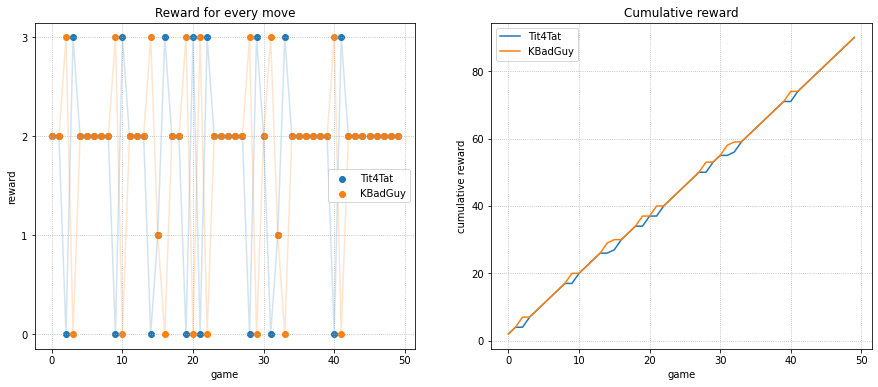

In [9]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

# for practicity we are using u as horizontal arrays
# initialize players instances
p1 = Tit4Tat([],[],[])
p2 = KBadGuy(40,[],[])

# game loop
for i in range(50):
    u1 = p1.move()
    u2 = p2.move()
    #append p2 move, necessary for the tit4tat
    p1.append_input(u2)
    
    p1.append_reward(np.array(u1) @ M @ np.array(u2).T)
    p2.append_reward(np.array(u2) @ M @ np.array(u1).T)

# visualization
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(p1.r_history, alpha=0.2)
ax[0].scatter(range(len(p1.r_history)), p1.r_history, label=(type(p1).__name__),)
ax[0].plot(p2.r_history, alpha=0.2)
ax[0].scatter(range(len(p2.r_history)), p2.r_history,  label=(type(p2).__name__),)
ax[0].legend()
ax[0].set_yticks(range(0,4))
ax[0].set_xlabel("game")
ax[0].set_ylabel("reward")
ax[0].set_title("Reward for every move")

ax[1].plot(np.cumsum(p1.r_history), label=(type(p1).__name__))
ax[1].plot(np.cumsum(p2.r_history), label=(type(p2).__name__))
ax[1].legend()
ax[0].grid(linestyle=":")
ax[1].set_xlabel("game")
ax[1].set_ylabel("cumulative reward")
ax[1].set_title("Cumulative reward")
ax[1].grid(linestyle=":")


print(f"{type(p1).__name__} final reward {sum(p1.r_history)}")
print(f"{type(p2).__name__} final reward {sum(p2.r_history)}")

## Tit4Tat vs Tit4Tat
They start by cooperating and continue to cooperate. They finish with the higher overall reward.

Tit4Tat final reward 200
Tit4Tat final reward 200


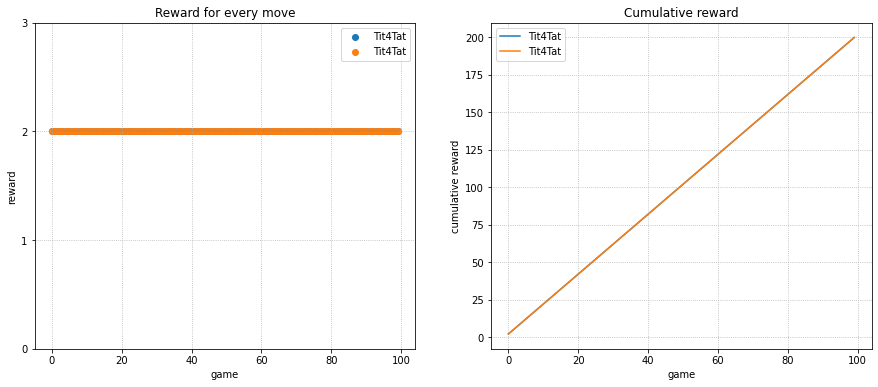

In [10]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

# for practicity we are using u as horizontal arrays
# initialize players instances
p1 = Tit4Tat([],[],[])
p2 = Tit4Tat([],[],[])

# game loop
for i in range(100):
    u1 = p1.move()
    p2.append_input(u1)
    
    u2 = p2.move()
    p1.append_input(u2)
        
    p1.append_reward(np.array(u1) @ M @ np.array(u2).T)
    p2.append_reward(np.array(u2) @ M @ np.array(u1).T)
    
# visualization    
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(p1.r_history, alpha=0.2)
ax[0].scatter(range(len(p1.r_history)), p1.r_history, label=(type(p1).__name__),)
ax[0].plot(p2.r_history, alpha=0.2)
ax[0].scatter(range(len(p2.r_history)), p2.r_history,  label=(type(p2).__name__),)
ax[0].legend()
ax[0].set_yticks(range(0,4))
ax[0].grid(linestyle=":")
ax[0].set_xlabel("game")
ax[0].set_ylabel("reward")
ax[0].set_title("Reward for every move")

ax[1].plot(np.cumsum(p1.r_history), label=(type(p1).__name__))
ax[1].plot(np.cumsum(p2.r_history), label=(type(p2).__name__))
ax[1].legend()
ax[1].set_xlabel("game")
ax[1].set_ylabel("cumulative reward")
ax[1].set_title("Cumulative reward")
ax[1].grid(linestyle=":")


print(f"{type(p1).__name__} final reward {sum(p1.r_history)}")
print(f"{type(p2).__name__} final reward {sum(p2.r_history)}")


## KBadGuy vs KBadGuy
The KBadGuy with higher k parameter tends to win.

player1 final reward  73
player2 final reward  109


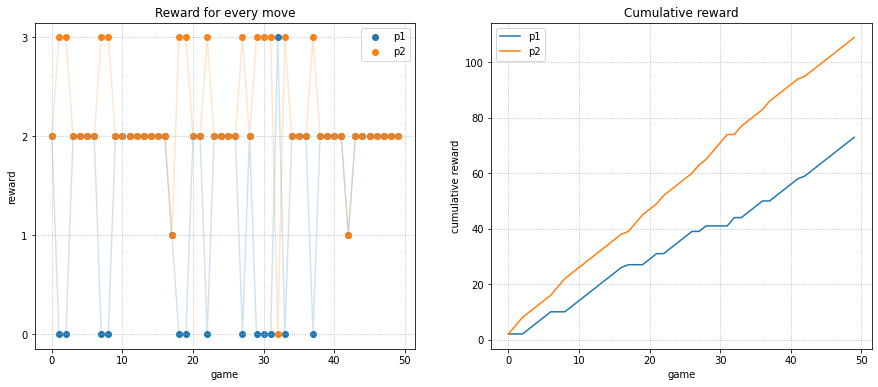

In [11]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

# initialize players instances
p1 = KBadGuy(10,[],[])
p2 = KBadGuy(30,[],[])

# game loop
for i in range(50):
    u1 = p1.move()
#     p2.append_input(u1)
    
    u2 = p2.move()
#     p1.append_input(u2)
        
    p1.append_reward(np.array(u1) @ M @ np.array(u2).T)
    p2.append_reward(np.array(u2) @ M @ np.array(u1).T)
    
# visualization
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(p1.r_history, alpha=0.2)
ax[0].scatter(range(len(p1.r_history)), p1.r_history, label=("p1"),)
ax[0].plot(p2.r_history, alpha=0.2)
ax[0].scatter(range(len(p2.r_history)), p2.r_history,  label=("p2"),)
ax[0].legend()
ax[0].set_yticks(range(0,4))
ax[0].set_xlabel("game")
ax[0].set_ylabel("reward")
ax[0].set_title("Reward for every move")
ax[0].grid(linestyle=":")

ax[1].plot(np.cumsum(p1.r_history), label=("p1"))
ax[1].plot(np.cumsum(p2.r_history), label=("p2"))
ax[1].legend()
ax[1].set_xlabel("game")
ax[1].set_ylabel("cumulative reward")
ax[1].set_title("Cumulative reward")
ax[1].grid(linestyle=":")


print("player1 final reward ", sum(p1.r_history))
print("player2 final reward ", sum(p2.r_history))


## Explore the entire range of KBadGuys

We can generalize the previous cell. The entire range of the KBadGuys comprends the NiceGuy (with *k*=0), the BadGuy (with *k*=100) and every strategy inbetween, so we run every possible game while varying the *k* in the two players. We also want to analize the connection between the two *k* values and the overall reward value.

Since every tournament is defined on the variation on two parameters we need to display the reward in a figure using two axis and color. With this result we can prove that the higher overall reward is obtained when the two players have a low *k* parameter.
So the higher individual reward is obtained with a defective strategy, but the higher group reward, intended as the summation of the individual rewards, is obtained with a cooperative behaviour on both players.

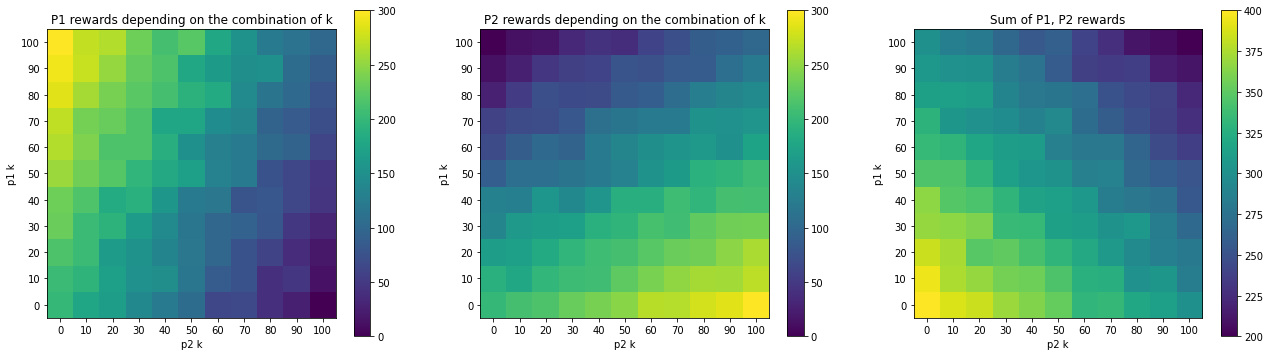

In [12]:

# Payoff matrix
M = np.array([[2,0],[3,1]])

k_p1 = np.arange(0, 101, 10)
k_schedule = np.zeros((121,2))

for i in range(0,121,11):
    k_schedule[i:i+11, 0] = k_p1[i//11]
    k_schedule[i:i+11, 1] = k_p1[:]


reward_history = []
for n in range(np.shape(k_schedule)[0]):
    reward_game = [0,0]
    p1 = KBadGuy(k_schedule[n,0],[],[])
    p2 = KBadGuy(k_schedule[n,1],[],[])
    for i in range(100):              
        u1 = p1.move()
        u2 = p2.move()

        reward1 = np.array(u1) @ M @ np.array(u2).T
        reward2 = np.array(u2) @ M @ np.array(u1).T
        p1.append_reward(reward1)
        p2.append_reward(reward2)
        
        reward_game[0] += reward1
        reward_game[1] += reward2
        
    reward_history.append(reward_game)
    
reward_history = np.asarray(reward_history)
reward_2d = np.reshape(reward_history, (11,11,2))

# visualization    
# fig, ax = plt.subplots(1,2, figsize = (15,6))
# ax[0].plot(reward_history[:,0], label=("p1"))
# ax[0].plot(reward_history[:,1], label=("p2"))
# ax[0].legend()
# ax[0].grid(linestyle=":")
# ax[0].set_title("final rewards for the combinations of k")
# ax[1].plot(np.sum(reward_history,1), label=("p1"))
# ax[1].grid(linestyle=":")
# ax[1].set_title("Sum of the final reward for both players")


fig, ax = plt.subplots(1,3, figsize = (22,6))
im0 = ax[0].imshow(reward_2d[:,:,0], origin='lower')
ax[0].set_xticks(range(11))
ax[0].set_yticks(range(11))
ax[0].set_xticklabels(range(0,110,10))
ax[0].set_yticklabels(range(0,110,10))
ax[0].set_xlabel("p2 k")
ax[0].set_ylabel("p1 k")
ax[0].set_title("P1 rewards depending on the combination of k")
plt.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(reward_2d[:,:,1], origin='lower')
ax[1].set_xticks(range(11))
ax[1].set_yticks(range(11))
ax[1].set_xticklabels(range(0,110,10))
ax[1].set_yticklabels(range(0,110,10))
ax[1].set_xlabel("p2 k")
ax[1].set_ylabel("p1 k")
ax[1].set_title("P2 rewards depending on the combination of k")
plt.colorbar(im1, ax=ax[1])

im2 = ax[2].imshow(np.sum(reward_2d, 2), origin='lower')
ax[2].set_xticks(range(11))
ax[2].set_yticks(range(11))
ax[2].set_xticklabels(range(0,110,10))
ax[2].set_yticklabels(range(0,110,10))
ax[2].set_xlabel("p2 k")
ax[2].set_ylabel("p1 k")
ax[2].set_title("Sum of P1, P2 rewards")
plt.colorbar(im2, ax=ax[2])

plt.show()

## Introducing the LookBack Player

The LookBack Player uses the past rewards to choose the best strategy in its next move. It compute the summtion of the rewards obtained for every move and it chooses the one with the higher rewards. During the first move, or when the rewards are equal, it chooses randomly. 

We can use a bias that is added to rewards while computing the move decision. This is necessary because with a payoff matrix that has average greater than zero, the LookBack Player tends to simply choose the same move that it has already used from the beginning of the game. So using a bias that is equal to the negative average of the payoff matrix the player decision is not skewed towards the move it has performed more frequently.

We want to see how the LookBack Player performs against a KBadGuy and also if it is able to adopt a cooperative behaviour that maximizes the group reward.

In the following game we see that the LookBack Player tends to win against a MainlyNiceGuy, but we will generalize the behaviour against a KBadGuy later.

KBadGuy final reward 25
LookBackPlayer final reward 103


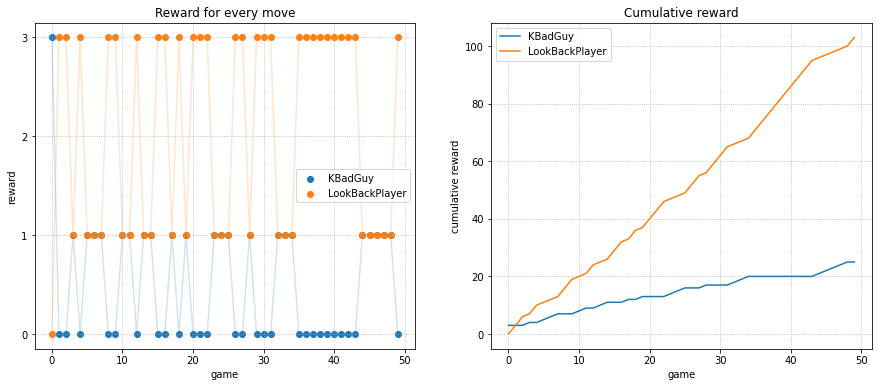

In [13]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

p1 = KBadGuy(40,[],[])
p2 = LookBackPlayer(-1.5,[],[])

for i in range(50):
    u1 = p1.move()
    u2 = p2.move()
    
    p1.append_reward(np.array(u1) @ M @ np.array(u2).T)
    p2.append_reward(np.array(u2) @ M @ np.array(u1).T)
    
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(p1.r_history, alpha=0.2)
ax[0].scatter(range(len(p1.r_history)), p1.r_history, label=(type(p1).__name__),)
ax[0].plot(p2.r_history, alpha=0.2)
ax[0].scatter(range(len(p2.r_history)), p2.r_history,  label=(type(p2).__name__),)
ax[0].legend()
ax[0].grid(linestyle=":")
ax[0].set_yticks(range(0,4))
ax[0].set_xlabel("game")
ax[0].set_ylabel("reward")
ax[0].set_title("Reward for every move")

ax[1].plot(np.cumsum(p1.r_history), label=(type(p1).__name__))
ax[1].plot(np.cumsum(p2.r_history), label=(type(p2).__name__))
ax[1].legend()
ax[1].set_xlabel("game")
ax[1].set_ylabel("cumulative reward")
ax[1].set_title("Cumulative reward")
ax[1].grid(linestyle=":")

print(f"{type(p1).__name__} final reward {sum(p1.r_history)}")
print(f"{type(p2).__name__} final reward {sum(p2.r_history)}")

### LookBack Player vs LookBack Player
It is interesting to test the performances of a LooKBack Player against another LookBackPlayer. In this case, after few moves, they adopt a cooperative behaviour that maximizes the group reward.

LookBackPlayer1 final reward 197
LookBackPlayer2 final reward 194


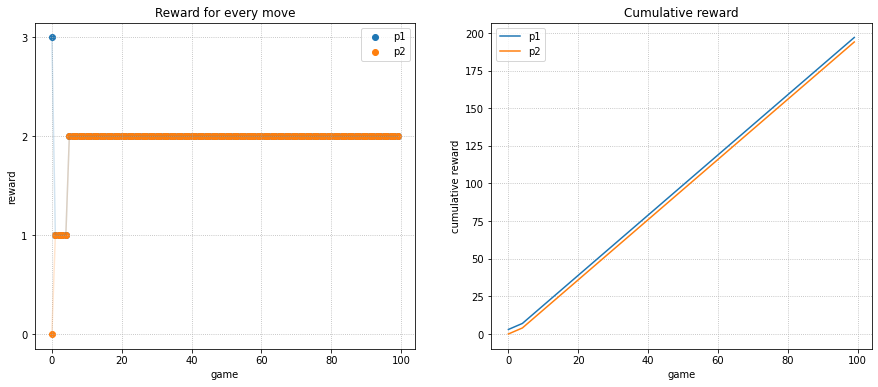

In [14]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

p1 = LookBackPlayer(-1.5,[],[])
p2 = LookBackPlayer(-1.5,[],[])

for i in range(100):
    u1 = p1.move()
    u2 = p2.move()
    
    p1.append_reward(np.array(u1) @ M @ np.array(u2).T)
    p2.append_reward(np.array(u2) @ M @ np.array(u1).T)

    
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(p1.r_history, alpha=0.2)
ax[0].scatter(range(len(p1.r_history)), p1.r_history, label=("p1"),)
ax[0].plot(p2.r_history, alpha=0.2)
ax[0].scatter(range(len(p2.r_history)), p2.r_history,  label=("p2"),)
ax[0].legend()
ax[0].grid(linestyle=":")
ax[0].set_yticks(range(0,4))
ax[0].set_xlabel("game")
ax[0].set_ylabel("reward")
ax[0].set_title("Reward for every move")

ax[1].plot(np.cumsum(p1.r_history), label=("p1"))
ax[1].plot(np.cumsum(p2.r_history), label=("p2"))
ax[1].legend()
ax[1].set_xlabel("game")
ax[1].set_ylabel("cumulative reward")
ax[1].set_title("Cumulative reward")
ax[1].grid(linestyle=":")

print(f"{type(p1).__name__}1 final reward {sum(p1.r_history)}")
print(f"{type(p2).__name__}2 final reward {sum(p2.r_history)}")

### LookBack player against every k bad player
We want to test the LookBackPlayer performances against every KBadGuy. The LookBack Player it is able to win against every KBadGuy that has a *k* parameter lower than circa *k*=85.  
As before, we see that the group reward is higher when the KBadGuy has a more cooperative behaviour.


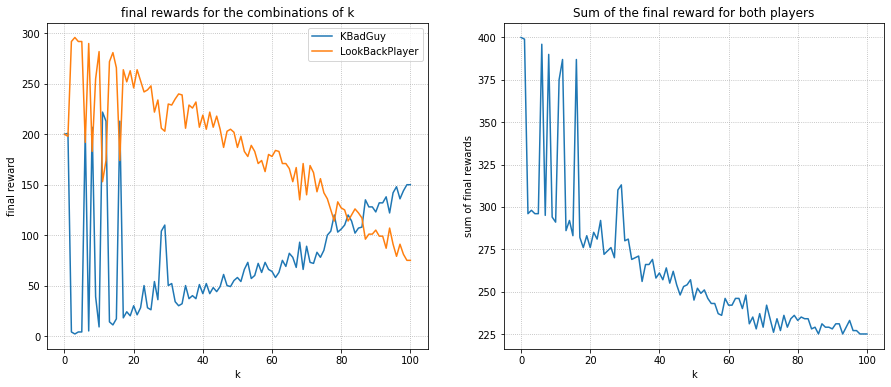

In [15]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

k_p1 = np.arange(0, 101, 10)
k_schedule = np.arange(101)
# k_schedule = np.flip(k_schedule)

reward_history = []
for n in range(np.shape(k_schedule)[0]):
    reward_game = [0,0]
    p1 = KBadGuy(k_schedule[n],[],[])
    p2 = LookBackPlayer(-1.5,[],[])
   
    for i in range(100):          
        u1 = p1.move()
        u2 = p2.move()

        reward1 = np.array(u1) @ M @ np.array(u2).T
        reward2 = np.array(u2) @ M @ np.array(u1).T
        p1.append_reward(reward1)
        p2.append_reward(reward2)
        
        reward_game[0] += reward1
        reward_game[1] += reward2
        
    reward_history.append(reward_game)
    
reward_history = np.asarray(reward_history)
# reward_2d = np.reshape(reward_history, (10,10,2))

# print(reward_history)
# visualization    
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(reward_history[:,0], label=("KBadGuy"))
ax[0].plot(reward_history[:,1], label=("LookBackPlayer"))
ax[0].legend()
ax[0].grid(linestyle=":")
ax[0].set_title("final rewards for the combinations of k")
ax[0].set_xlabel("k")
ax[0].set_ylabel('final reward')

ax[1].plot(np.sum(reward_history,1), label=("p1"))
ax[1].grid(linestyle=":")
ax[1].set_title("Sum of the final reward for both players")
ax[1].set_xlabel("k")
ax[1].set_ylabel('sum of final rewards')

plt.show()

### LookBack player against every k bad player 
We run the previous game multiple times in order to reduce the effect of the randomness and see more clearly the regularities on the games results. We plot the the average reward on 50 runs of the games, and we mark with a shaded area the standard deviation.



In [16]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

k_p1 = np.arange(0, 101, 10)
k_schedule = np.arange(101)


reward_history = []
std_history =[]

games_per_batch = 50
for n in range(np.shape(k_schedule)[0]):
    reward_game_batch = [0,0]
    std_history_batch = []
    
    for j in range(games_per_batch):
        reward_game = [0,0]
        p1 = KBadGuy(k_schedule[n],[],[])
        p2 = LookBackPlayer(-1.5,[],[])
        for i in range(100):      
            u1 = p1.move()
            u2 = p2.move()

            reward1 = np.array(u1) @ M @ np.array(u2).T
            reward2 = np.array(u2) @ M @ np.array(u1).T
            p1.append_reward(reward1)
            p2.append_reward(reward2)

            reward_game[0] += reward1
            reward_game[1] += reward2
        
        std_history_batch.append(reward_game)
        reward_game_batch[0] += reward_game[0]
        reward_game_batch[1] += reward_game[1]
    
    std_history.append(std_history_batch)
    reward_history.append(reward_game_batch)

std_history = np.array(std_history)


reward_history = np.asarray(reward_history)/games_per_batch
# print(np.shape(std_history))

std = np.std(std_history, axis=1)
# print(np.shape(std))

std_history_sum = np.sum(std_history, axis=2)
std_sum =np.std(std_history_sum, axis=1)
# print(np.shape(std_history_sum))
reward_history_sum = np.sum(reward_history,1)
# print(np.shape(reward_history_sum))

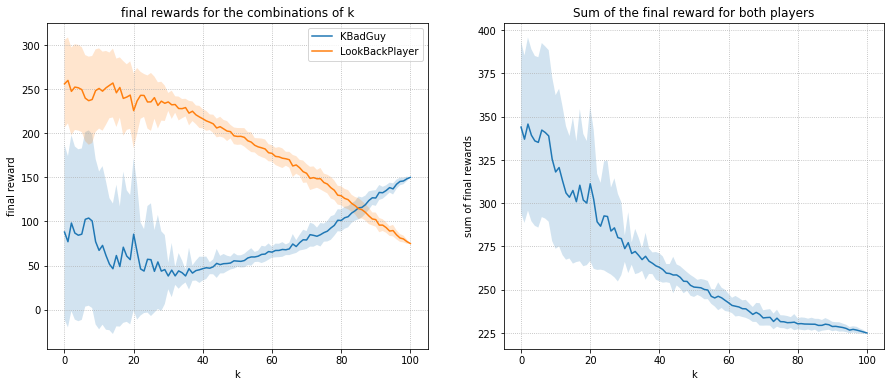

In [17]:
# visualization    
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(reward_history[:,0], label=("KBadGuy"))
ax[0].fill_between(range(np.shape(k_schedule)[0]), reward_history[:,0]+std[:,0],  reward_history[:,0]-std[:,0], alpha=0.2)
ax[0].plot(reward_history[:,1], label=("LookBackPlayer"))
ax[0].fill_between(range(np.shape(k_schedule)[0]), reward_history[:,1]+std[:,1],  reward_history[:,1]-std[:,1], alpha=0.2)
ax[0].legend()
ax[0].grid(linestyle=":")
ax[0].set_title("final rewards for the combinations of k")
ax[0].set_xlabel("k")
ax[0].set_ylabel('final reward')

ax[1].plot(reward_history_sum, label=("p1"))
ax[1].fill_between(range(np.shape(k_schedule)[0]), reward_history_sum+std_sum,  reward_history_sum-std_sum, alpha=0.2)
ax[1].grid(linestyle=":")
ax[1].set_title("Sum of the final reward for both players")
ax[1].set_xlabel("k")
ax[1].set_ylabel('sum of final rewards')

plt.show()

# Part 2: multiplayer IPD


In order to extend our game to a N-Players scenario, we started from the normal form matrix proposed in [1]:
<br><br>
$$
\begin{gather*}
    \text{Number of cooperators among the remaining $n-1$ players}\\
    \text{Player $i$}
    \begin{pmatrix}
        0 & 2 & 4 & \textbf{...} & 2(n-1)\\
        1 & 3 & 5 & \textbf{...} & 2(n-1)+1\\
    \end{pmatrix}
\end{gather*}\\
$$
<br>
Where in the first row we have the player payoffs when he chooses to collaborate, and in the second one the payoffs when he decides to defect.

Thanks to this new payoff matrix, we can simply compute the i-th player payoff as:
<br><br>
$$
u_{i} =
\begin{cases}
    2(n_c-1)\quad\text{if player $i$ is collaborating}\\
    2n_c+1\quad\text{if player $i$ is defecting}
\end{cases}
$$<br>
where $c$ is the number of cooperators among the remaining $n-1$ players.<br>
Thanks to this game formulation, we can easly compute the average per-round payoff $a$:<br><br>
$$
a = 1 + \frac{N_c}{N}(2N-3)
$$
<br>
where:
$$
\begin{cases}
    N_c = \text{number of collaborating players}\\
    N = \text{number of players in the game}
\end{cases}
$$


References:<br>
[1]: https://link.springer.com/chapter/10.1007/3-540-60154-6_50

In [18]:
def calc_reward(Nc, c):
    if(c == 0): #not collaborating
        return 2*(Nc)+1
    
    else:
        return 2*(Nc-1)


#P_list = player list
#GI = number of Game Iterations
def MPIPD(P_list, GI):
    # game loop
    for i in range(GI):

        U = np.array([P_list[i].move() for i in range(len(P_list))]).T #matrix with all the players move of this round
        Nc = np.sum(U[0,:])#number of collaborating players
        
        for k in range(len(P_list)):   #for each player    
            
            
            #Calculate rewards
            P_list[k].append_reward(calc_reward(Nc, U[0, k]))
            

            #check if player is tit4tat, if yes, update input history
            if(isinstance(P_list[k], Tit4Tat)):

                if(Nc > np.ceil(len(P))/2): #at lest 50% are collaborating
                    P_list[k].append_input([1,0])

                else: #less than 50% are collaborating                
                    P_list[k].append_input([0,1])
                    
            if(isinstance(P_list[k], Tit4TatMP) or isinstance(P_list[k], GrimTriggerMP)):
                P_list[k].append_input(np.delete(U, k, axis=1).T)

            


#P_list = player list
#P_plot_index = indexes of the player that we want to plot
def plot_rewards_MPIPD(P_list, P_plot_index=None):        

    if(P_plot_index == None): 
        P_plot_index = range(len(P_list))
        
        
    fig, ax = plt.subplots(1,2, figsize = (15,6))

    for i in P_plot_index:

        print("player"+ str(i) +" final reward "+ str(sum(P_list[i].r_history)) +". Player type: " + str(type(P_list[i]).__name__))
        ax[0].scatter(range(len(P_list[i].r_history)),P_list[i].r_history, alpha=0.7, marker=".", s=300)
        ax[1].plot(np.cumsum(P_list[i].r_history), label=str(type(P_list[i]).__name__))
        ax[1].legend()


player0 final reward 449. Player type: Tit4Tat
player1 final reward 428. Player type: KBadGuy
player2 final reward 272. Player type: NiceGuy
player3 final reward 431. Player type: KBadGuy


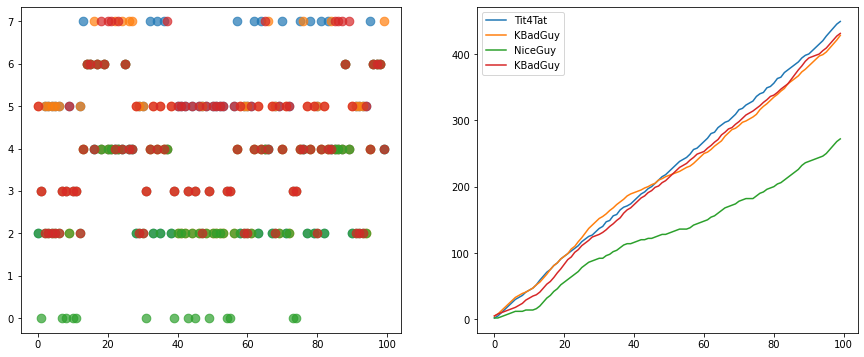

player0 final reward 301. Player type: Tit4TatMP
player4 final reward 295. Player type: GrimTriggerMP
player5 final reward 160. Player type: LookBackPlayer


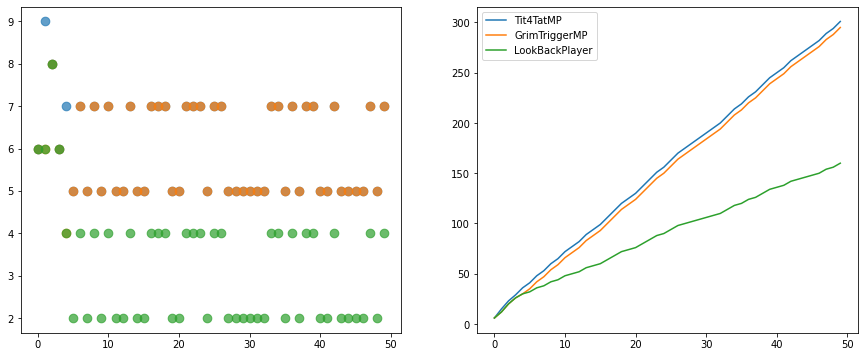

In [19]:
# initialize players instances

p1 = Tit4Tat([],[],[])
p2 = KBadGuy(40,[],[])
p3 = NiceGuy([],[])
p4 = BadGuy([],[])
p5 = KBadGuy(60,[],[])

P = [p1, p2, p3, p5]

#run the game
MPIPD(P, 100)

#plot the results
plot_rewards_MPIPD(P)

plt.show()

p1 = Tit4TatMP([],[],[],0.7)
p2 = KBadGuy(60,[],[])
p3 = NiceGuy([],[])
p4 = BadGuy([],[])
p5 = GrimTriggerMP([],[],[],0.4)
p6 = LookBackPlayer(-1.5,[],[])

P = [p1, p2, p3, p4, p5, p6]

MPIPD(P, 50)
plot_rewards_MPIPD(P,[0,4,5])

plt.show()

# Part 3: reapeted multiplayer IPD with population increasing
Iterate what done in the previous task (repeated MPIPD, rMPIPD)  by increasing the population implementing a given strategy depending on the results that strategy achieved in the previous iteration

In [20]:
class NiceGuy(Player):
    """
    Player that always outputs the cooperate move
    """
    def __init__(self, r_history=[], move_history=[]):
        self.r_history = r_history
        self.move_history = move_history
        self.label = "NiceGuy"
        
    def append_reward(self, reward):
        self.r_history.append(reward)
        
    def move(self):
        uc = [1,0]
        self.move_history.append(uc)
        return uc
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []

    
class BadGuy(Player):
    """
    Player that always outputs the defect move
    """
    def __init__(self, r_history=[], move_history=[]):
        self.r_history = r_history
        self.move_history = move_history
        self.label = "BadGuy"
        
    def append_reward(self, reward):
        self.r_history.append(reward)
        
    def move(self):
        ud = [0,1]
        self.move_history.append(ud)
        return ud
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []

    
class KBadGuy(Player):
    """
    Player that outputs the defect move 
    with probability k/100
    """
    def __init__(self, k, r_history=[], move_history=[]):
        self.k = k
        self.r_history = r_history
        self.move_history = move_history
        self.label = str(k) + "BadGuy"
        
    def append_reward(self, reward):
        self.r_history.append(reward)
        
    def move(self):
        uc = [1,0]
        ud = [0,1]
        if np.random.rand() > 1-(self.k/100):
            u = ud
        else:
            u = uc        
        self.move_history.append(u)
        return u
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []
 
    
class Tit4Tat(Player):
    """
    Player, the first move is cooperate, 
    the subsequent moves are the same as the last 
    element in self.input_history
    """
    def __init__(self, r_history=[], move_history=[], input_history=[]):
        self.r_history = r_history
        self.move_history = move_history 
        self.input_history = input_history

    def append_reward(self, reward):
        self.r_history.append(reward)

    def append_input(self, inp):
        self.input_history.append(inp)

    def move(self):
        if len(self.input_history) == 0:
            u = [1,0]
        else:
            u = self.input_history[-1]
        self.move_history.append(u)
        return u
    
class Tit4TatMP(Player):
    """
    Player that starts with cooperate and then cooperates only if a fraction of players
    above or equal c_treshold has cooperated.
    """
    def __init__(self, r_history=[], move_history=[], input_history=[], c_threshold=0.5):
        self.r_history = r_history
        self.move_history = move_history 
        self.input_history = input_history
        self.c_threshold = c_threshold
        self.label = str(c_threshold) + "Tit4TatMP"
    
    def append_reward(self, reward):
        self.r_history.append(reward)
        
    def append_input(self, m_inp):
        """
        multiplayer input m_inp should be an array or list with N rows for N players,
        in every row the list [1,0] or [0,1], it also works with [1] or [0].
        The number of input players can change. 
        """
        self.input_history.append(m_inp)
        
    def move(self):
        if len(self.input_history) == 0:
            u = [1,0]
        else:
            last_inp = np.array(self.input_history[-1])[:,0]
            if np.sum(last_inp)/np.shape(last_inp)[0] >= self.c_threshold:
                u = [1,0]
            else:
                u = [0,1]
        self.move_history.append(u)
        return u
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []
        self.input_history = []
        
        
class GrimTriggerMP(Player):
    """
    Player that cooperates until a numbers of players >= d_threshold defect in a turn,
    from now on he defects in every turn. 
    Setting d_threshold=0 means that it needs only one defecting player
    to start defecting itself.
    """
    def __init__(self, r_history=[], move_history=[], input_history=[], d_threshold=0.5):
        self.r_history = r_history
        self.move_history = move_history 
        self.input_history = input_history
        self.d_threshold = d_threshold
        self.defected = False
        self.label = str(d_threshold) + "GrimTriggerMP"
    
    def append_reward(self, reward):
        self.r_history.append(reward)  
        
    def append_input(self, m_inp):
        """
        multiplayer input m_inp should be an array or list with N rows for N players,
        in every row the list [1,0] or [0,1], it also works with [1] or [0].
        The number of input players can change. 
        """
        self.input_history.append(m_inp)
    
    def move(self):  
        if not self.defected and len(self.input_history) > 0:
            # check if it has been defected in the last turn
            last_inp = last_inp = np.array(self.input_history[-1])[:,0]
            if np.sum(last_inp)/np.shape(last_inp)[0] < 1 - self.d_threshold:
                self.defected = True
#                 print("debug DEFECTED")
                
        if not self.defected:
            u = [1,0]
        else:
            u = [0,1]
        self.move_history.append(u)
        return u
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []
        self.input_history = []

    
    
class LookBackPlayer(Player):
    """
    Player that use past rewards in order to decide the next move.
    """
    def __init__(self, bias, r_history=[], move_history=[], delta = 1):
        """
        bias is added to the past rewards during the move decision
        if bias is in range [-3,0] it can change the behaviour of the player
        """
        self.r_history = r_history
        self.move_history = move_history 
        self.bias = bias
        self.delta = delta
        self.label = str(delta) + "LookBackPlayer"
    
    def append_reward(self, reward):
        self.r_history.append(reward)
    

    def move(self):       
        # random move if its the first move
        if len(self.r_history) == 0:
            if np.random.rand() >= 0.5:
                u = [1,0]
            else:
                u = [0,1]
        else:            
            move_cat_history = np.array(self.move_history)
            deltas = np.array([self.delta**i for i in range(len(move_cat_history))])
            deltas = np.hstack((deltas,deltas))
            r_cat_history = np.concatenate((np.array([self.r_history]).T,np.array([self.r_history]).T), axis=1)
            sum_cat_r = np.sum((r_cat_history + self.bias) * move_cat_history, axis=0)

            if sum_cat_r[0]>sum_cat_r[1]:
                # cooperate 
                u = [1,0]
            elif sum_cat_r[0]<sum_cat_r[1]:
                # defect 
                u = [0,1]
            else:
                # random choice if parity
                if np.random.rand() >= 0.5:
                    u = [1,0]
                else:
                    u = [0,1]
                
        self.move_history.append(u)
        return u
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []

## ```rMPIPD```
Function that takes as input an initial list of players and let them play in ```MPIPD``` for a number of iterations specified as input (100 as default). The function then adds a player whose type will be chosen among the others who have already played according to one of the following criteria given as input:
<ul>
    <li> Player who achieved maximum final reward (default) </li>
    <li> Randomly </li>
    <li> Player who gained minimum final reward </li>
</ul>
The procedure is then repeated for a number of repetitions given as input (30 as default).
The function finally creates a graph concerning the rewards of the initial players along the different matches and a graph that shows which players (they are usually more than one) gained the biggest final reward in every match and which player was added time by time.

In [21]:
import copy
def rMPIPD(P_list,criterium = "max",rep_num=30,iter_num=100):
    num_p = len(P_list)
    p_rewards = np.zeros((num_p,rep_num))
    winners = np.zeros((num_p,rep_num))
    for j in range(rep_num):
        for pers in P:
            pers.p_reset()
        for player in P_list:
            if type(player).__name__ == "LookBackPlayer":
                player.bias = -1*(len(P_list)-0.5)
        MPIPD(P, iter_num)
        rewards = np.array([np.sum(P_list[i].r_history) for i in range(len(P))])
        p_rewards[:,j] = rewards[0:num_p]
        i = np.where(rewards==max(rewards))
        labels = np.array(list(map(lambda x: x.label, P_list)))
        lab, indexes = np.unique(labels[i[0]], return_index = True)
        i = i[0][indexes]
        if i[i<num_p].size > 0:
            winners[i[i<num_p],j] += 1
        new_pl_win = i[i>=num_p]
        for h in range(new_pl_win.size):
            k = 0
            while labels[k] != labels[new_pl_win[h]]:
                k += 1
            winners[k,j] += 1
        if "max" in criterium:
            histories = np.array(list(map(lambda x: x.move_history , [P_list[k] for k in i])))
            count = np.zeros((histories.shape[2]))
            if i.size > 1 and criterium=="max_r":
                i = i[np.random.randint(0,i.size)]
            elif i.size > 1 and criterium=="max_c":
                for history,k in zip(histories,range(count.size)):
                    count[k] = history[history==np.array([1,0])].size
                j = np.where(count==max(count))[0]
                if j.size == 1:
                    i = i[j]
                else:
                    i = i[np.random.choice(j)]
            elif i.size > 1 and criterium=="max_d":
                for history,k in zip(histories,range(count.size)):
                    count[k] = history[history==np.array([0,1])].size
                j = np.where(count==max(count))[0]
                if j.size == 1:
                    i = i[j]
                else:
                    i = i[np.random.choice(j)]
            else:
                i = int(i)
        elif criterium=="random":
            i = np.random.randint(num_p)
        elif "min" in criterium:
            i = np.where(rewards==min(rewards))[0]
            histories = np.array(list(map(lambda x: x.move_history , [P_list[k] for k in i])))
            count = np.zeros((histories.shape[2]))
            if i.size > 1 and criterium=="min_r":
                i = i[np.random.randint(0,i.size)]
            elif i.size > 1 and criterium=="min_c":
                for history,k in zip(histories,range(count.size)):
                    count[k] = history[history==np.array([1,0])].size
                j = np.where(count==max(count))[0]
                if j.size == 1:
                    i = i[j]
                else:
                    i = i[np.random.choice(j)]
            elif i.size > 1 and criterium=="min_d":
                for history,k in zip(histories,range(count.size)):
                    count[k] = history[history==np.array([0,1])].size
                j = np.where(count==max(count))[0]
                if j.size == 1:
                    i = i[j]
                else:
                    i = i[np.random.choice(j)]
            else:
                i = int(i)
        new_p = copy.deepcopy(P_list[i])
        P_list.append(new_p)
    
    input_labels = np.array(list(map(lambda x: x.label, P_list[:num_p])))
    win_data = np.where(winners!=0)
    u = np.unique(win_data[0])
    plt.scatter(win_data[1],win_data[0], label="Highest payoff")
    added_labels = np.array(list(map(lambda x: x.label, P_list[num_p:])))
    u = np.unique(added_labels)
    print("  Number of added players")
    for j in range(0,u.size):
        print(u[j] + " : " + str(added_labels[added_labels==u[j]].size))
    added_data = []
    for i in range(added_labels.size):
        j = 0
        while added_labels[i]!=input_labels[j]:
            j += 1
        added_data.append(j)
    plt.scatter(range(rep_num), added_data, marker='s', s=70, facecolors='none', edgecolors='r', label="Added")
    plt.yticks(range(num_p), input_labels)
    plt.legend(bbox_to_anchor=(1.05,1))
    plt.show() 
        
    for i in range(num_p):
        plt.plot(range(rep_num),p_rewards[i],label=P_list[i].label)
    plt.legend(bbox_to_anchor=(1.05,1))
    plt.show()

  Number of added players
1LookBackPlayer : 4
NiceGuy : 26


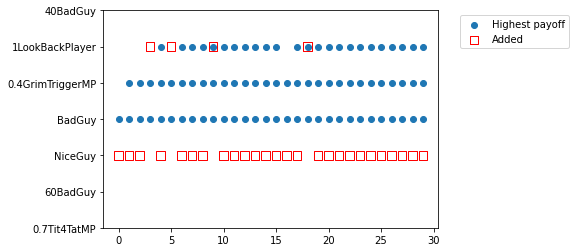

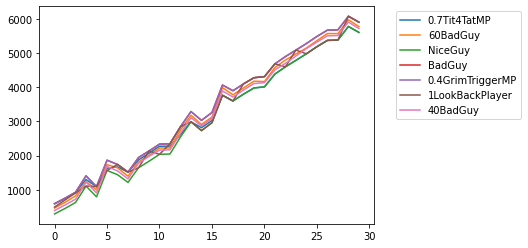

In [22]:
p1 = Tit4TatMP([],[],[],0.7)
p2 = KBadGuy(60,[],[])
p3 = NiceGuy([],[])
p4 = BadGuy([],[])
p5 = GrimTriggerMP([],[],[],0.4)
p6 = LookBackPlayer(-1.5,[],[])
p7 = KBadGuy(40,[],[])

P = [p1, p2, p3, p4, p5, p6, p7]

rMPIPD(P,"min_r")

  Number of added players
0.5GrimTriggerMP : 16
BadGuy : 14


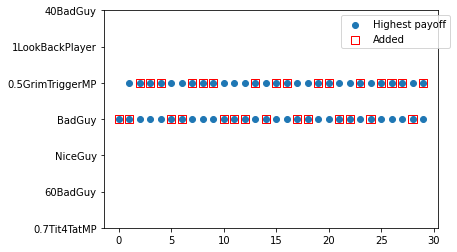

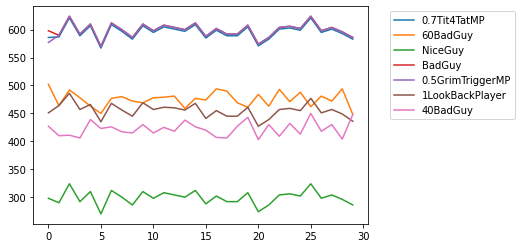

  Number of added players
0.8GrimTriggerMP : 13
BadGuy : 17


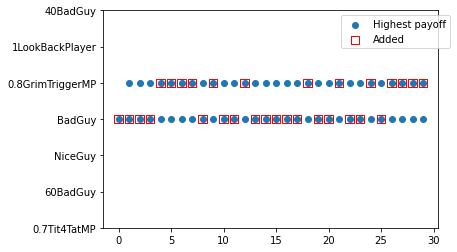

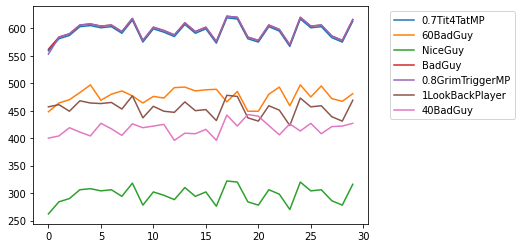

  Number of added players
BadGuy : 30


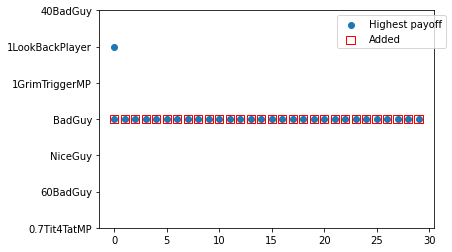

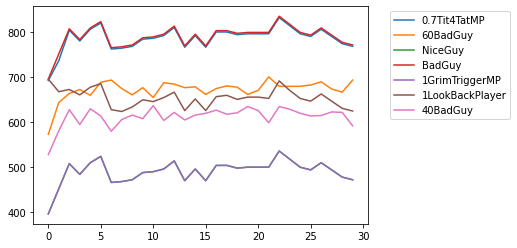

In [23]:
p1 = Tit4TatMP([],[],[],0.7)
p2 = KBadGuy(60,[],[])
p3 = NiceGuy([],[])
p4 = BadGuy([],[])
p5 = GrimTriggerMP([],[],[],0.5)
p6 = LookBackPlayer(-1.5,[],[])
p7 = KBadGuy(40,[],[])

P = [p1, p2, p3, p4, p5, p6, p7]

rMPIPD(P,"max_c")

p1 = Tit4TatMP([],[],[],0.7)
p2 = KBadGuy(60,[],[])
p3 = NiceGuy([],[])
p4 = BadGuy([],[])
p5 = GrimTriggerMP([],[],[],0.8)
p6 = LookBackPlayer(-1.5,[],[])
p7 = KBadGuy(40,[],[])

P = [p1, p2, p3, p4, p5, p6, p7]

rMPIPD(P,"max_c")

p1 = Tit4TatMP([],[],[],0.7)
p2 = KBadGuy(60,[],[])
p3 = NiceGuy([],[])
p4 = BadGuy([],[])
p5 = GrimTriggerMP([],[],[],1)
p6 = LookBackPlayer(-1.5,[],[])
p7 = KBadGuy(40,[],[])

P = [p1, p2, p3, p4, p5, p6, p7]

rMPIPD(P,"max_c")

  Number of added players
75BadGuy : 13
80BadGuy : 17


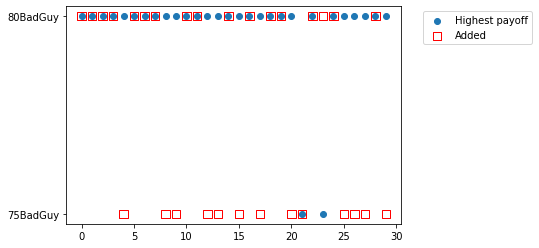

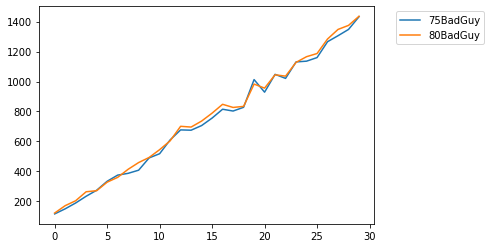

In [24]:
p1 = KBadGuy(75,[],[])
p2 = KBadGuy(80,[],[])

P = [p1,p2]

rMPIPD(P,"random")

  Number of added players
0Tit4TatMP : 1
1GrimTriggerMP : 2
1LookBackPlayer : 27


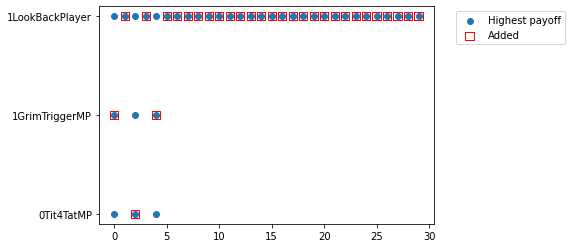

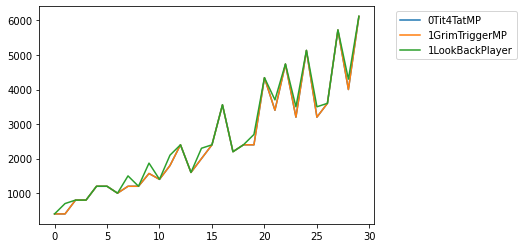

In [25]:
p1 = Tit4TatMP([],[],[],0)
p2 = GrimTriggerMP([],[],[],1)
p3 = LookBackPlayer(-1.5,[],[],1)

P = [p1,p2,p3]

rMPIPD(P,"max_c")

  Number of added players
0Tit4TatMP : 1
1LookBackPlayer : 29


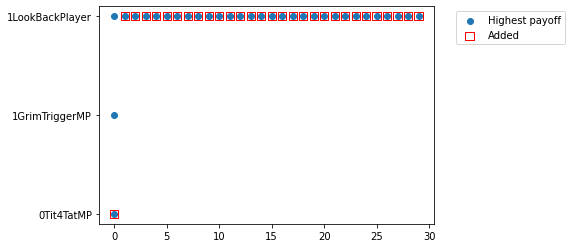

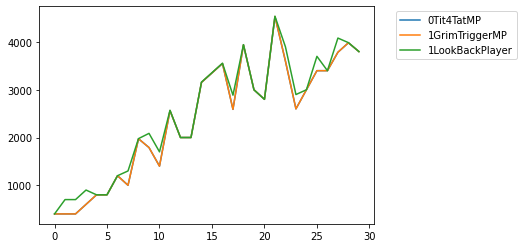

In [26]:
p1 = Tit4TatMP([],[],[],0)
p2 = GrimTriggerMP([],[],[],1)
p3 = LookBackPlayer(-1.5,[],[],1)

P = [p1,p2,p3]

rMPIPD(P,"max_r")

  Number of added players
1LookBackPlayer : 30


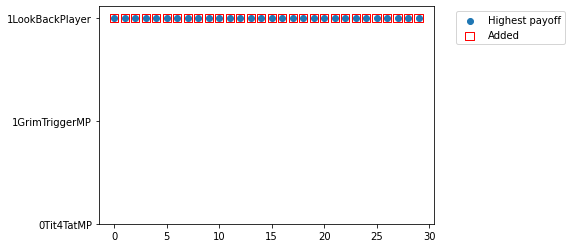

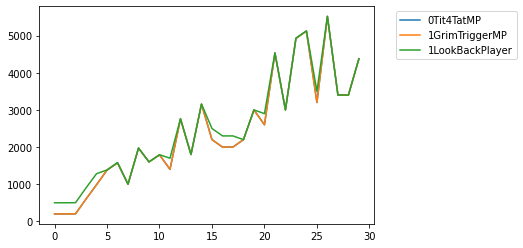

In [27]:
p1 = Tit4TatMP([],[],[],0)
p2 = GrimTriggerMP([],[],[],1)
p3 = LookBackPlayer(-1.5,[],[],1)

P = [p1,p2,p3]

rMPIPD(P,"max_d")

  Number of added players
0.5GrimTriggerMP : 28
50BadGuy : 2


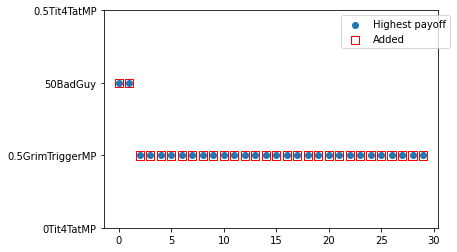

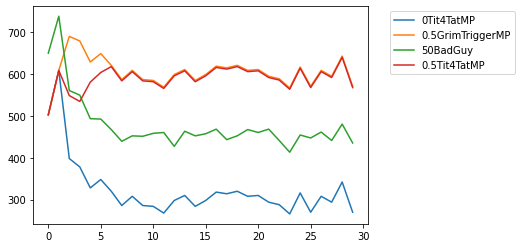

In [28]:
p1 = Tit4TatMP([],[],[],0)
p2 = GrimTriggerMP([],[],[],0.5)
p3 = KBadGuy(50,[],[])
p4 = Tit4TatMP([],[],[],0.5)

P = [p1,p2,p3,p4]

rMPIPD(P,"max_r")

# Part4: rMPIPD with mutating strategies
(*difficult*) Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natura selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined. 